# Notebook

## Cleaning the Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import code.data_preparation as dp
import code.visualizations as viz
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, ADASYN
import missingno as msno
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Here is the data provided.

In [3]:
train_values = pd.read_csv('data/training_set_values.csv', parse_dates=['date_recorded'])
train_values.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...    never pay   
4  31.130847  -1.825359               Shuleni            0  ...    never pay   

  water_quality quality_group      quantity  quantity_group  \
0          soft          good        enough          enough   
1          soft          good  insufficient    insufficient   
2          soft          good        enough          enough   
3          soft          good           dry             dry   
4          soft          good      seasonal        seasonal   

                 source           source_type  source_class  \
0                spring                spring   groundwater   
1  rainwater harvesting  rainwater harvesting       surface   
2                   dam                   dam       surface   
3           machine dbh              borehole   groundwater   
4  rainwater harvesting  rainwater harvesting       surface   

               waterpoint_type waterpoint_type_group  
0           communal standpipe    communal standpipe  
1           communal standpipe    communal standpipe  
2  communal standpipe multiple    communal standpipe  
3  communal standpipe multiple    communal standpipe  
4           communal standpipe    communal standpipe  

[5 rows x 40 columns]

In [4]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 55765 non-null  object        
 4   gps_height             59400 non-null  int64         
 5   installer              55745 non-null  object        
 6   longitude              59400 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59400 non-null  object        
 9   num_private            59400 non-null  int64         
 10  basin                  59400 non-null  object        
 11  subvillage             59029 non-null  object        
 12  region                 59400 non-null  object        
 13  r

### Missing Values

As we can see there are a number of columns with missing values, all of them are object datatypes, which makes deciding what to do with them more complex.

In [5]:
train_values.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Using missing no to visualize the nan values, there is no apparent underlying pattern to the missing values.

<AxesSubplot:>

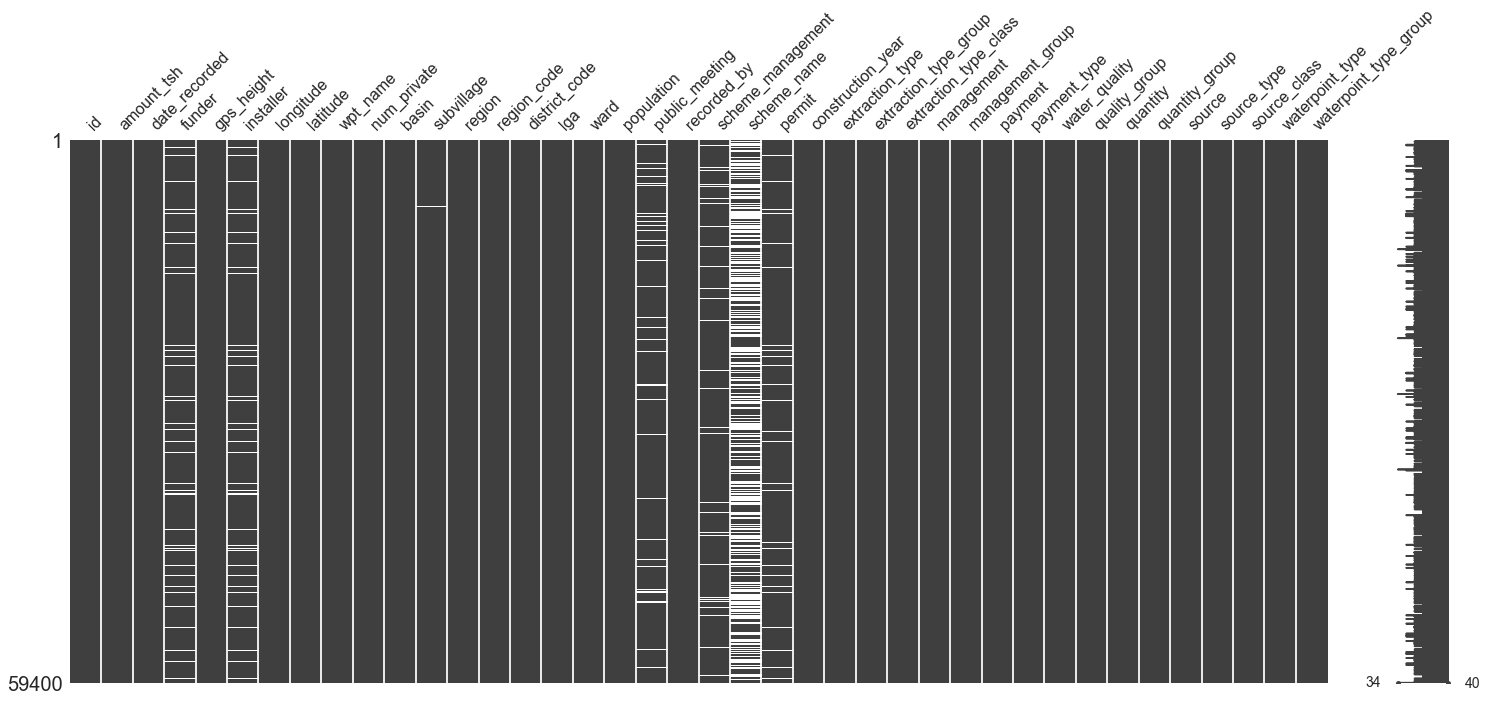

In [6]:
msno.matrix(train_values)

Let's take a closer look at these values to see if there is a reasonable value to imput for the missing values, or whether we should just label them unknown.

### *Funder and Installer*

In [7]:
train_values.funder.value_counts().head(30)

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
0                          777
Norad                      765
Germany Republi            610
Tcrs                       602
Ministry Of Water          590
Water                      583
Dwe                        484
Netherlands                470
Hifab                      450
Adb                        448
Lga                        442
Amref                      425
Fini Water                 393
Oxfam                      359
Wateraid                   333
Rc Church                  321
Isf                        316
Name: funder, dtype: int64

In [8]:
train_values.funder.value_counts().tail(20)

B.A.P                          1
Sagaswe                        1
Tkc                            1
Bhws                           1
Cvs Miss                       1
Tgt                            1
Padri K                        1
Hesswa                         1
Afya Department Lindi Rural    1
Ramadhani M. Mvugalo           1
Tlc/thimotheo Masunga          1
Quick Wins Scheme              1
Mnyama                         1
Thomasi Busigaye               1
Samweli                        1
Dqnida                         1
Artisan                        1
Nmdc India                     1
Rural                          1
Hesawwa                        1
Name: funder, dtype: int64

Let's take a closer look at the '0' value in funder.

In [9]:
train_values[train_values['funder']=='0'].head(10)

id  amount_tsh date_recorded funder  gps_height installer  longitude  \
145  28669        50.0    2013-03-21      0          12         0  39.185710   
152  60983         0.0    2013-03-16      0         -15         0  39.527114   
393  39749         0.0    2013-03-18      0          28         0  39.159887   
417  15832        50.0    2013-03-22      0          30         0  39.178404   
428  50233         0.0    2013-03-12      0          30         0  39.178849   
503  26293         0.0    2013-03-18      0         -17         0  39.433715   
567  69018       100.0    2013-03-18      0          58         0  39.135409   
636  54848         0.0    2013-03-14      0         -17         0  39.441638   
702   6002        50.0    2013-03-19      0          84         0  39.116554   
797  72237         0.0    2013-03-15      0          62         0  39.080763   

     latitude       wpt_name  num_private  ... payment_type    water_quality  \
145 -6.892593       Chekanao            0  ...   per bucket             soft   
152 -6.988748      Msikitini            0  ...    never pay            salty   
393 -6.902548   Kwa Chambuso            0  ...      unknown          unknown   
417 -6.938013     Ccm Kivule            0  ...   per bucket             soft   
428 -6.973206  Ofisi Ya Kata            0  ...    never pay          unknown   
503 -7.096279        Shuleni            0  ...    never pay            salty   
567 -6.913908           none            0  ...   per bucket  salty abandoned   
636 -6.901908       Kwa Weso            0  ...   per bucket            salty   
702 -6.890041  Kwa Mzee Iddy            0  ...   per bucket             soft   
797 -7.000181         Office            0  ...      unknown          unknown   

    quality_group  quantity  quantity_group        source   source_type  \
145          good    enough          enough   machine dbh      borehole   
152         salty       dry             dry   machine dbh      borehole   
393       unknown   unknown         unknown   machine dbh      borehole   
417          good    enough          enough   machine dbh      borehole   
428       unknown       dry             dry  shallow well  shallow well   
503         salty       dry             dry   machine dbh      borehole   
567         salty    enough          enough   machine dbh      borehole   
636         salty       dry             dry   machine dbh      borehole   
702          good    enough          enough   machine dbh      borehole   
797       unknown   unknown         unknown  shallow well  shallow well   

     source_class     waterpoint_type waterpoint_type_group  
145   groundwater  communal standpipe    communal standpipe  
152   groundwater               other                 other  
393   groundwater               other                 other  
417   groundwater  communal standpipe    communal standpipe  
428   groundwater               other                 other  
503   groundwater               other                 other  
567   groundwater  communal standpipe    communal standpipe  
636   groundwater  communal standpipe    communal standpipe  
702   groundwater  communal standpipe    communal standpipe  
797   groundwater               other                 other  

[10 rows x 40 columns]

Let's check to see if they have commonalities in region, management, or installer.

In [10]:
zero_funder = train_values[train_values['funder']=='0']
zero_funder.groupby(['region', 'management', 'installer']).count()

id  amount_tsh  date_recorded  \
region        management       installer                                   
Dar es Salaam company          0            1           1              1   
              other            0            1           1              1   
              other - school   0           99          99             99   
              parastatal       0           67          67             67   
              private operator 0          211         211            211   
              unknown          0            6           6              6   
              vwc              0          169         169            169   
              wua              0            1           1              1   
              wug              0          222         222            222   

                                          funder  gps_height  longitude  \
region        management       installer                                  
Dar es Salaam company          0               1           1          1   
              other            0               1           1          1   
              other - school   0              99          99         99   
              parastatal       0              67          67         67   
              private operator 0             211         211        211   
              unknown          0               6           6          6   
              vwc              0             169         169        169   
              wua              0               1           1          1   
              wug              0             222         222        222   

                                          latitude  wpt_name  num_private  \
region        management       installer                                    
Dar es Salaam company          0                 1         1            1   
              other            0                 1         1            1   
              other - school   0                99        99           99   
              parastatal       0                67        67           67   
              private operator 0               211       211          211   
              unknown          0                 6         6            6   
              vwc              0               169       169          169   
              wua              0                 1         1            1   
              wug              0               222       222          222   

                                          basin  ...  payment_type  \
region        management       installer         ...                 
Dar es Salaam company          0              1  ...             1   
              other            0              1  ...             1   
              other - school   0             99  ...            99   
              parastatal       0             67  ...            67   
              private operator 0            211  ...           211   
              unknown          0              6  ...             6   
              vwc              0            169  ...           169   
              wua              0              1  ...             1   
              wug              0            222  ...           222   

                                          water_quality  quality_group  \
region        management       installer                                 
Dar es Salaam company          0                      1              1   
              other            0                      1              1   
              other - school   0                     99             99   
              parastatal       0                     67             67   
              private operator 0                    211            211   
              unknown          0                      6              6   
              vwc              0                    169            169   
              wua              0                      1              1   
              wug    

All the 0 values are in a single region. There seems to be a correlation between 0s in the funder column and installer column, so before deciding what to do let's look more closely at the installer data.

In [11]:
zero_installer = train_values[train_values['installer']=='0']
zero_installer.groupby(['region', 'management', 'funder']).count()

id  amount_tsh  date_recorded  \
region        management       funder                                   
Dar es Salaam company          0         1           1              1   
              other            0         1           1              1   
              other - school   0        99          99             99   
              parastatal       0        67          67             67   
              private operator 0       211         211            211   
              unknown          0         6           6              6   
              vwc              0       169         169            169   
              wua              0         1           1              1   
              wug              0       222         222            222   

                                       gps_height  installer  longitude  \
region        management       funder                                     
Dar es Salaam company          0                1          1          1   
              other            0                1          1          1   
              other - school   0               99         99         99   
              parastatal       0               67         67         67   
              private operator 0              211        211        211   
              unknown          0                6          6          6   
              vwc              0              169        169        169   
              wua              0                1          1          1   
              wug              0              222        222        222   

                                       latitude  wpt_name  num_private  basin  \
region        management       funder                                           
Dar es Salaam company          0              1         1            1      1   
              other            0              1         1            1      1   
              other - school   0             99        99           99     99   
              parastatal       0             67        67           67     67   
              private operator 0            211       211          211    211   
              unknown          0              6         6            6      6   
              vwc              0            169       169          169    169   
              wua              0              1         1            1      1   
              wug              0            222       222          222    222   

                                       ...  payment_type  water_quality  \
region        management       funder  ...                                
Dar es Salaam company          0       ...             1              1   
              other            0       ...             1              1   
              other - school   0       ...            99             99   
              parastatal       0       ...            67             67   
              private operator 0       ...           211            211   
              unknown          0       ...             6              6   
              vwc              0       ...           169            169   
              wua              0       ...             1              1   
              wug              0       ...           222            222   

                                       quality_group  quantity  \
region        management       funder                            
Dar es Salaam company          0                   1         1   
              other            0                   1         1   
              other - school   0                  99        99   
              parastatal       0                  67        67   
              private operator 0                 211       211   
              unknown          0                   6         6   
              vwc              0                 169       169   
              wua              0                   1         1   
              wug              0

In [12]:
train_values.installer.value_counts().head(30)

DWE                   17402
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
LGA                     408
World vision            408
WEDECO                  397
TASAF                   396
District council        392
Gover                   383
AMREF                   329
TWESA                   316
WU                      301
Dmdd                    287
ACRA                    278
World Vision            270
SEMA                    249
DW                      246
OXFAM                   234
Name: installer, dtype: int64

There are the same number of 0s for installer and funder. There also seem to be repeat entries due to data entry problems for example 'Commu' and 'Community' or 'District Council and 'District council' and 'Gover', 'Government' and 'Central Government'.

Before dealing with that issue let's first look at the null values in more detail to decide what to do with them before cleaning up the data entry issues.

In [13]:
nan_funder = train_values[train_values['funder'].isna()]
nan_funder.groupby(['region', 'management', 'installer']).count()

id  amount_tsh  date_recorded  \
region    management       installer                                         
Arusha    parastatal       ISSAC MOLLEL       3           3              3   
                           ISSAC MOLLEl       1           1              1   
                           VWC                1           1              1   
                           WORLD VISION       1           1              1   
          unknown          DWE                2           2              2   
          vwc              DWE                2           2              2   
                           VWC                1           1              1   
Dodoma    vwc              GOVER              1           1              1   
                           Gove               2           2              2   
Iringa    vwc              Angli              1           1              1   
                           DWE                1           1              1   
                           rc ch              1           1              1   
          wua              UNICEF             1           1              1   
Kagera    vwc              DW                18          18             18   
Mara      private operator Shule              1           1              1   
                           marafip            1           1              1   
          unknown          Privat             1           1              1   
          vwc              MINISTRYOF WATER   1           1              1   
Morogoro  vwc              DHV Moro           1           1              1   
Mwanza    vwc              HESAWA             1           1              1   
Rukwa     vwc              DWE                2           2              2   
Shinyanga parastatal       DWE                2           2              2   
                           OXFAM              1           1              1   
                           RWSSP              1           1              1   
          wug              DWE                3           3              3   
Tabora    vwc              GOVERNMENT         2           2              2   

                                             funder  gps_height  longitude  \
region    management       installer                                         
Arusha    parastatal       ISSAC MOLLEL           0           3          3   
                           ISSAC MOLLEl           0           1          1   
                           VWC                    0           1          1   
                           WORLD VISION           0           1          1   
          unknown          DWE                    0           2          2   
          vwc              DWE                    0           2          2   
                           VWC                    0           1          1   
Dodoma    vwc              GOVER                  0           1          1   
                           Gove                   0           2          2   
Iringa    vwc              Angli                  0           1          1   
                           DWE                    0           1          1   
                           rc ch                  0           1          1   
          wua              UNICEF                 0           1          1   
Kagera    vwc              DW                     0          18         18   
Mara      private operator Shule                  0           1          1   
                           marafip                0           1          1   
          unknown          Privat                 0           1          1   
          vwc              MINISTRYOF WATER       0           1          1   
Morogoro  vwc              DHV Moro               0           1          1   
Mwanza    vwc              HESAWA                 0           1          1   
Rukwa     vwc              DWE                    0           2          2   
Shinyanga parastatal       DWE                    0           2   

In [14]:
nan_installer = train_values[train_values['installer'].isna()]
nan_installer.groupby(['region', 'management', 'funder']).count()

id  amount_tsh  \
region      management  funder                                           
Arusha      parastatal  Fredked Conservation             1           1   
                        Rc Church                        1           1   
                        Wfp                              2           2   
            vwc         District Council                 1           1   
                        Ministry Of Agricultura          1           1   
                        Ministry Of Water                4           4   
Iringa      vwc         Shipo                            1           1   
Kagera      other       Not Known                        1           1   
            vwc         Aar                              1           1   
                        Hesawa                           1           1   
Kigoma      water board Norad                            1           1   
Kilimanjaro other       Grazie Grouppo Padre Fiorentin   1           1   
Lindi       unknown     World Bank                       1           1   
            vwc         Government Of Tanzania           1           1   
Mara        other       Maro Kyariga                     1           1   
            vwc         Hesawa                           1           1   
Morogoro    vwc         Donor                            1           1   
                        Government Of Tanzania           1           1   
                        Solidarm                         1           1   
            wug         Member O                         1           1   
Mtwara      vwc         Lga                              1           1   
Mwanza      other       Bgssws                           1           1   
                        Ms-danish                        1           1   
            parastatal  Bhws                             1           1   
            vwc         Gg                               1           1   
                        Ggm                              2           2   
                        Government Of Tanzania           1           1   
                        Hesawa                           3           3   
                        Jica                             1           1   
                        One Desk One Chair               1           1   
Pwani       vwc         Wsdp                             1           1   
Rukwa       vwc         Dw                               1           1   
Shinyanga   parastatal  Government Of Tanzania           1           1   
                        Rural Water Supply And Sanitat   1           1   
                        Rwssp                            1           1   
            unknown     Community                        1           1   
                        Koica And Tanzania Government    1           1   
                        World Bank                       5           5   
            vwc         World Bank                       4           4   
            wug         Abddwe                           1           1   
                        Rural Water Supply And Sanitat   3           3   
                        Tasaf                            1           1   
                        World Vision                     7           7   
Singida     unknown     Rundu Man                        1           1   
            vwc         Tcrs                             1           1   
Tabora      other       Worldvision                      1           1   
            vwc         Community                        2           2   
                        None                             2           2   
                        World Bank                       1           1   

                                                        date_recorded  \
region      management  funder                                          
Arusha      parastatal  Fredked Conservation                        1   
                        Rc Church                             

In [15]:
train_values[train_values['funder']=='Not Known']

id  amount_tsh date_recorded     funder  gps_height  \
35     57355         0.0    2013-03-28  Not Known        1546   
1426   31672         0.0    2013-03-23  Not Known        1871   
1649   52401         0.0    2013-03-21  Not Known        1650   
2730   40815         0.0    2011-07-23  Not Known           0   
5650   18845         0.0    2013-03-28  Not Known        1540   
11421  25965         0.0    2011-07-21  Not Known           0   
16506   8481         0.0    2011-03-03  Not Known          85   
18721  50608         0.0    2011-07-10  Not Known           0   
20352  26841         0.0    2011-07-27  Not Known           0   
23841  28739         0.0    2011-07-27  Not Known           0   
25449  19977         0.0    2011-03-03  Not Known          93   
27136  15750         0.0    2013-03-21  Not Known        1648   
31148  50897         0.0    2011-03-16  Not Known           8   
35455  63334         0.0    2011-03-03  Not Known          99   
38676  17305         0.0    2011-08-02  Not Known           0   
41431  68288         0.0    2011-07-20  Not Known           0   
42042   5871         0.0    2013-03-21  Not Known        1633   
42403  14336         0.0    2013-03-21  Not Known        1837   
43941  40342         0.0    2013-03-23  Not Known        1872   
44615  12147         0.0    2013-03-30  Not Known        1523   
44946    373         0.0    2013-03-16  Not Known         965   
46986   9180         0.0    2011-07-22  Not Known           0   
49685  11621         0.0    2011-07-10  Not Known           0   
50612  73727         0.0    2013-03-30  Not Known        1498   
51291  35541         0.0    2013-03-28  Not Known        1559   
54971  25106         0.0    2013-03-21  Not Known        1644   
58748  41242         0.0    2011-08-08  Not Known           0   

                        installer  longitude  latitude  \
35                      Not known  36.618699 -3.293003   
1426                    Not known  36.644556 -3.244199   
1649                    Not known  36.720357 -3.130001   
2730                    not known  32.639752 -2.709872   
5650                    Not known  36.618545 -3.292390   
11421                         NaN  30.714453 -2.905798   
16506                   not known  38.376294 -6.708447   
18721                   Not known  31.755311 -2.639781   
20352  Sengerema Water Department  32.777487 -2.526449   
23841  Sengerema Water Department  32.793434 -2.527674   
25449                   not known  38.375609 -6.708948   
27136                   Not known  36.720995 -3.129200   
31148                   Not known  39.185553 -7.365037   
35455                   not known  38.372789 -6.709759   
38676                   villagers  32.425625 -2.337271   
41431                       RIDEP  32.535942 -2.713298   
42042                   Not known  36.719657 -3.125816   
42403                   Not known  36.695417 -3.153203   
43941                   Not known  36.644487 -3.244144   
44615                   Not known  36.644866 -3.320243   
44946                   Not known  36.850948 -3.493453   
46986                   not known  32.718579 -2.571346   
49685                   Not known  31.751096 -2.642831   
50612                   Not known  36.646382 -3.321824   
51291                   Not known  36.618736 -3.292075   
54971                   Not known  36.720442 -3.129696   
58748                   Villagers  32.147940 -2.445560   

                     wpt_name  num_private  ... payment_type water_quality  \
35                  Sekondari            0  ...    never pay          soft   
1426           Kituo Cha Afya            0  ...    never pay          soft   
1649          Shule Ya Msingi            0  ...    never pay          soft   
2730                 Kwa Kali            0  ...    never pay          soft   
5650          Shule Ya Msingi            0  ...    never pay          soft   
11421                   Ndege            0  ...    never pay       unknown   
16506             

Unlike the 0 values which were correlated between each other and in a single region, the null values seem fairly random and are like just missing due to error, whereas the 0 value seems like a consistent single funder in a particular region. We will leave the 0 values as is, treating 0 as a name and label the missing values as 'not known' values.

We will also lower case both columns to help with data entry issue and replace some clearly equivalent entries.

In [16]:
train_values[['funder', 'installer']] = train_values[['funder', 'installer']].fillna('not known')
for col in ['funder', 'installer']:
    train_values[col] = train_values[col].str.lower()

In [17]:
replace_dict = {'commu':  'community',
                'gover': 'government',
                'central government': 'government',
                'government of tanzania': 'government',
                'gove': 'government',
                'worldvision' : 'world vision',
                'private individual': 'private',
                'privat': 'private',
                'priv': 'private'}
                
train_values[['funder', 'installer']] = train_values[['funder', 'installer']].replace(replace_dict)

In [18]:
train_values.installer.value_counts().head(30)

dwe                 17405
not known            3696
government           3387
community            1620
hesawa               1395
rwe                  1206
danida               1050
district council      961
kkkt                  910
0                     777
tcrs                  707
world vision          699
danid                 624
ces                   610
amref                 443
lga                   413
tasaf                 411
wedeco                398
fini water            389
dmdd                  376
norad                 360
twesa                 316
da                    308
wu                    301
acra                  278
sema                  249
dw                    246
jaica                 239
unicef                234
oxfam                 234
Name: installer, dtype: int64

In [19]:
train_values.funder.value_counts().head(30)

government           9086
not known            3662
danida               3114
hesawa               2202
rwssp                1374
world bank           1349
kkkt                 1287
world vision         1247
private              1121
unicef               1057
tasaf                 877
district council      843
dhv                   829
dwsp                  811
0                     777
norad                 765
germany republi       610
tcrs                  602
ministry of water     590
water                 583
dwe                   484
netherlands           470
hifab                 450
adb                   448
lga                   442
amref                 425
fini water            393
oxfam                 359
wateraid              333
rc church             321
Name: funder, dtype: int64

### *Subvillage*

Let's get a general sense of this data first

In [20]:
train_values.subvillage.value_counts().head(30)

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Mlimani       152
Songambele    147
Msikitini     134
Miembeni      134
1             132
Kibaoni       114
Kanisani      111
I             109
Mapinduzi     109
Mjini         108
Mjimwema      108
Mkwajuni      104
Mwenge        102
Azimio         98
Mabatini       98
Mbugani        95
Mission        95
Bwawani        91
Bondeni        90
Chang'Ombe     88
Zahanati       86
Name: subvillage, dtype: int64

In [21]:
len(train_values.subvillage.unique())

19288

In [22]:
sum(train_values['subvillage']=='0')

0

In [23]:
sum(train_values['subvillage']==0)

0

The data is high cardinality and there are some unusual values like '1' and 'I'. This level of detail migh cause over fitting and its information might be better captured by the lat long data, but for now we will label the missing values 'not known', and lower case the values to help with potential data entry errors.

In [24]:
train_values['subvillage'] = train_values['subvillage'].fillna('not known')
train_values['subvillage'] = train_values['subvillage'].str.lower()

### *Public Meeting*

In [25]:
train_values.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

Given that the vast majority of the data says that there are public meetings about the pump, we will impute the mode for this value, but add column marking the missing values.

In [26]:
train_values['missing_meeting'] = dp.missing_indicator(train_values, 'public_meeting')
train_values['public_meeting']=train_values['public_meeting'].fillna(train_values['public_meeting'].mode()[0])

### *Permit*

In [27]:
train_values.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

This is must less overwhelming in the ratio of true to false, so let's dig a bit deeper. Perhaps different types of managers are more likely to permit the pump.

In [28]:
train_values.groupby(['management_group','permit']).count()

id  amount_tsh  date_recorded  funder  gps_height  \
management_group permit                                                         
commercial       False     968         968            968     968         968   
                 True     2485        2485           2485    2485        2485   
other            False     186         186            186     186         186   
                 True      657         657            657     657         657   
parastatal       False     647         647            647     647         647   
                 True      948         948            948     948         948   
unknown          False     173         173            173     173         173   
                 True      346         346            346     346         346   
user-group       False   15518       15518          15518   15518       15518   
                 True    34416       34416          34416   34416       34416   

                         installer  longitude  latitude  wpt_name  \
management_group permit                                             
commercial       False         968        968       968       968   
                 True         2485       2485      2485      2485   
other            False         186        186       186       186   
                 True          657        657       657       657   
parastatal       False         647        647       647       647   
                 True          948        948       948       948   
unknown          False         173        173       173       173   
                 True          346        346       346       346   
user-group       False       15518      15518     15518     15518   
                 True        34416      34416     34416     34416   

                         num_private  ...  water_quality  quality_group  \
management_group permit               ...                                 
commercial       False           968  ...            968            968   
                 True           2485  ...           2485           2485   
other            False           186  ...            186            186   
                 True            657  ...            657            657   
parastatal       False           647  ...            647            647   
                 True            948  ...            948            948   
unknown          False           173  ...            173            173   
                 True            346  ...            346            346   
user-group       False         15518  ...          15518          15518   
                 True          34416  ...          34416          34416   

                         quantity  quantity_group  source  source_type  \
management_group permit                                                  
commercial       False        968             968     968          968   
                 True        2485            2485    2485         2485   
other            False        186             186     186          186   
                 True         657             657     657          657   
parastatal       False        647             647     647          647   
                 True         948             948     948          948   
unknown          False        173             173     173          173   
                 True         346             346     346          346   
user-group       False      15518           15518   15518        15518   
                 True       34416           34416   34416        34416   

                         source_class  waterpoint_type  waterpoint_type_group  \
management_group permit                                                         
commercial       False            968              968                    968   
                 True            2485             2485                   2485   
other            False            186              186                    186   
                 True          

The modal status for any of the management groups is that they are permitted, so we will impute the mode and add a column marking the missing data.

In [29]:
train_values['missing_permit'] = dp.missing_indicator(train_values, 'permit')
train_values['permit']=train_values['permit'].fillna(train_values['permit'].mode()[0])

### *Scheme Name and Managment*

Let's look at the clearly related scheme name and managment data more closely

In [30]:
train_values.scheme_name.value_counts().head(30)

K                                        682
None                                     644
Borehole                                 546
Chalinze wate                            405
M                                        400
DANIDA                                   379
Government                               320
Ngana water supplied scheme              270
wanging'ombe water supply s              261
wanging'ombe supply scheme               234
I                                        229
Bagamoyo wate                            229
Uroki-Bomang'ombe water sup              209
N                                        204
Kirua kahe gravity water supply trust    193
Machumba estate pipe line                185
Makwale water supplied sche              166
Kijiji                                   161
S                                        154
Handeni Trunk Main(H                     152
mtwango water supply scheme              152
Losaa-Kia water supply                   152
Mkongoro T

In [31]:
train_values.scheme_management.value_counts().head(30)

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [32]:
train_values.scheme_name.isna().sum()

28166

In [33]:
len(train_values.scheme_name.unique())

2697

Scheme name is high cardinality with a large numbe rof simply missing values, and what seem to be tons of data entry issues, we will drop is and only keep the scheme management values, since they are the sort of valueswe might be expecting are more likely and more easily correlated with the functioning of the pumps.

In [34]:
train_values = train_values.drop(columns=['scheme_name'])

Let's look more closely at the null values in the scheme management data to see if there is any pattern to help us possibly impute the data.

In [35]:
nan_scheme_man = train_values[train_values['scheme_management'].isna()]
nan_scheme_man.groupby(['management']).count()

id  amount_tsh  date_recorded  funder  gps_height  \
management                                                              
company              1           1              1       1           1   
other              186         186            186     186         186   
parastatal          11          11             11      11          11   
private operator   119         119            119     119         119   
trust                1           1              1       1           1   
unknown            468         468            468     468         468   
vwc               2450        2450           2450    2450        2450   
water authority      2           2              2       2           2   
wua                  6           6              6       6           6   
wug                633         633            633     633         633   

                  installer  longitude  latitude  wpt_name  num_private  ...  \
management                                                               ...   
company                   1          1         1         1            1  ...   
other                   186        186       186       186          186  ...   
parastatal               11         11        11        11           11  ...   
private operator        119        119       119       119          119  ...   
trust                     1          1         1         1            1  ...   
unknown                 468        468       468       468          468  ...   
vwc                    2450       2450      2450      2450         2450  ...   
water authority           2          2         2         2            2  ...   
wua                       6          6         6         6            6  ...   
wug                     633        633       633       633          633  ...   

                  quality_group  quantity  quantity_group  source  \
management                                                          
company                       1         1               1       1   
other                       186       186             186     186   
parastatal                   11        11              11      11   
private operator            119       119             119     119   
trust                         1         1               1       1   
unknown                     468       468             468     468   
vwc                        2450      2450            2450    2450   
water authority               2         2               2       2   
wua                           6         6               6       6   
wug                         633       633             633     633   

                  source_type  source_class  waterpoint_type  \
management                                                     
company                     1             1                1   
other                     186           186              186   
parastatal                 11            11               11   
private operator          119           119              119   
trust                       1             1                1   
unknown                   468           468              468   
vwc                      2450          2450             2450   
water authority             2             2                2   
wua                         6             6                6   
wug                       633           633              633   

                  waterpoint_type_group  missing_meeting  missing_permit  
management                                                                
company                               1                1               1  
other                               186              186             186  
parastatal                           11               11              11  
private operator                    119              119             119  
trust                                 1                1               1  
unknown                             468              468   

There is a correlation between the management values and the scheme management values with ther being many similar categories accross the two columns. We will impute that the missing values are the same between the two columns.

In [36]:
# lower casing so the scheme management values will align with those in the management column
train_values['scheme_management'] = train_values['scheme_management'].str.lower()
idx = train_values[train_values['scheme_management'].isna()].index
sm_column_num = train_values.columns.get_loc('scheme_management')
man_column_num = train_values.columns.get_loc('management')
train_values.iloc[idx, sm_column_num] = train_values.iloc[idx, man_column_num]

In [37]:
train_values.scheme_management.value_counts().head(15)

vwc                 39243
wug                  5839
water authority      3155
wua                  2889
water board          2748
parastatal           1691
private operator     1182
company              1062
other                 952
unknown               468
swc                    97
trust                  73
none                    1
Name: scheme_management, dtype: int64

In [38]:
train_values.isna().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
w

### Duplicate Columns or Values

There are no duplicate id numbers, so there are not obvious duplicate rows.

In [39]:
train_values.id.value_counts().max()

1

Many columns seem to contain very similar information.

#### *Potential Duplicate Columns: Extraction Type*

In [40]:
train_values.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [41]:
train_values.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [42]:
train_values.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

Of these three we will keep the most fine grained and the least and drop the type_group since we will likely get enough grouping information from the more general class.

#### *Potential Duplicate Columns: Management*

In [43]:
train_values.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [44]:
train_values.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

These contain fairly similar info, but the grouped data is more general and might capture patterns that only appear at that level of detail. Obviously this will increase the dimension and collinearity to some degree.

#### *Potential Duplicate Columns: Payment*

In [45]:
train_values.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [46]:
train_values.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

These are literally identical other than the wording for the categories, we will drop the type column.

#### *Potential Duplicate Columns: Water Quality*

In [47]:
train_values.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [48]:
train_values.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

These are at very similar level of detail with the none grouped data simply including extra info on if the source is abandoned. So, we will drop the group values.

#### *Potential Duplicate Columns: Water Quantity*

In [49]:
train_values.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [50]:
train_values.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

These columns are literally the same, so we will drop the group column.

#### *Potential Duplicate Columns: Source*

In [51]:
train_values.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [52]:
train_values.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [53]:
train_values.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

The source type and values are at a very similar level of detail with only minor differences, such as spliting river and lake or calling 'borehole' 'machine dbh', so keeping both doesn't really make sense. We will drop the type column, but keep the class and source columns, since the source contains some information on the similarities of the types of sources that could be useful.

#### *Potential Duplicate Columns: Waterpoint*

In [54]:
train_values.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [55]:
train_values.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

Since group contains all the information in type plus an extra category, we will drop the type column and keep the group.

Let's drop all the duplicates it made sense to drop. We left some in since removing them would likely reduce the models predictiveness, even if leaving them in does add some collinearity.

In [56]:
columns_dropped = ['extraction_type_group',
                   'payment_type',
                   'quality_group',
                   'quantity_group',
                   'source_type',
                   'waterpoint_type_group']
rm_duplicate_df = train_values.drop(columns = columns_dropped)

In [57]:
rm_duplicate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 59400 non-null  object        
 4   gps_height             59400 non-null  int64         
 5   installer              59400 non-null  object        
 6   longitude              59400 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59400 non-null  object        
 9   num_private            59400 non-null  int64         
 10  basin                  59400 non-null  object        
 11  subvillage             59400 non-null  object        
 12  region                 59400 non-null  object        
 13  r

## Location Data

Beyond lat-long there are a number of location data columns, let's look through them a bit to decide how to proceed.

In [58]:
train_values.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

This particular grouping will likely be useful since it affects water quality.

In [59]:
train_values.subvillage.value_counts()

madukani          508
shuleni           506
majengo           502
kati              373
not known         371
                 ... 
mahoha bondeni      1
ikukula             1
usandawi            1
kisaseni            1
kafika              1
Name: subvillage, Length: 19288, dtype: int64

In [60]:
(train_values.subvillage.value_counts()==1).sum()

9424

In [61]:
train_values.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [62]:
train_values.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [63]:
train_values.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [64]:
train_values.lga.value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [65]:
train_values.ward.value_counts()

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Thawi          1
Mawenzi        1
Sungwisi       1
Kinungu        1
Rasbura        1
Name: ward, Length: 2092, dtype: int64

In [66]:
(train_values.ward.value_counts()==1).sum()

30

It appears that in level of detail, it goes, region > district > lga > ward > subvillage > lat-long

We will drop the region columns since that data seems to be captured in the region codes, but will otherwise keep the others since they seem to be location groupings at different scales which might be useful for having information about different scales of geographic effects.

In [67]:
rm_duplicate_df = rm_duplicate_df.drop(columns = ['region'])

##### Unique Identifier info and Random Data

The id number and wpt_name which is the name of the individual waterpump shouldn't be used in predictions, since the whole point is to potentially make prediction about pumps not named in the data, and thus will be dropped. The num_private is a column that there is no info on what it represents and is filled with zero values. The 'recorded_by' column only has one value and thus will be useless. We will drop these as well.

In [68]:
rm_duplicate_df.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

In [69]:
clean_train_values = rm_duplicate_df.drop(columns = ['id', 'wpt_name', 'num_private', 'recorded_by'])

In [70]:
clean_train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   amount_tsh             59400 non-null  float64       
 1   date_recorded          59400 non-null  datetime64[ns]
 2   funder                 59400 non-null  object        
 3   gps_height             59400 non-null  int64         
 4   installer              59400 non-null  object        
 5   longitude              59400 non-null  float64       
 6   latitude               59400 non-null  float64       
 7   basin                  59400 non-null  object        
 8   subvillage             59400 non-null  object        
 9   region_code            59400 non-null  int64         
 10  district_code          59400 non-null  int64         
 11  lga                    59400 non-null  object        
 12  ward                   59400 non-null  object        
 13  p

## Looking at the Numerical Data

The numerical data is filled with zeros which are likely hidden missing values.

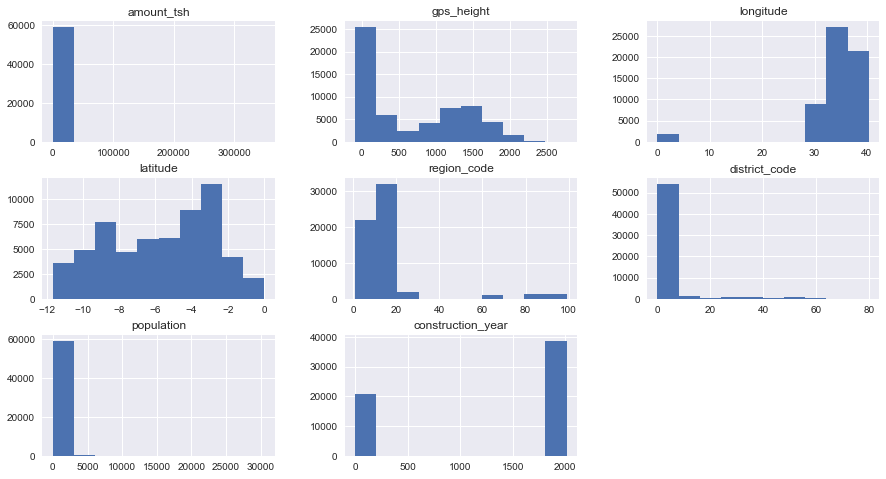

In [71]:
clean_train_values.select_dtypes(exclude=['object', 'bool']).hist(figsize = (15,8));

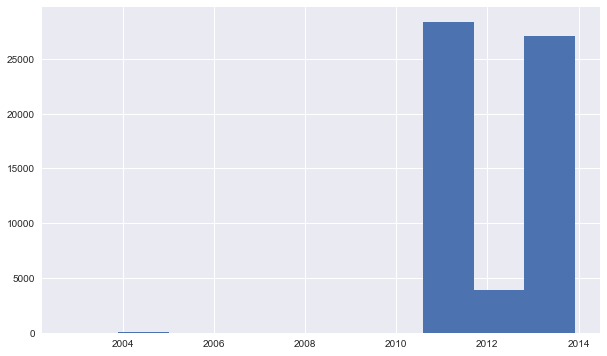

In [72]:
clean_train_values['date_recorded'].hist(figsize = (10,6));

### Dates and Construction Year

There are clearly many missing construction year values.

In [73]:
clean_train_values.construction_year.value_counts().head(10)

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
Name: construction_year, dtype: int64

Here is what the distribution looks like not includeing the 0 values.

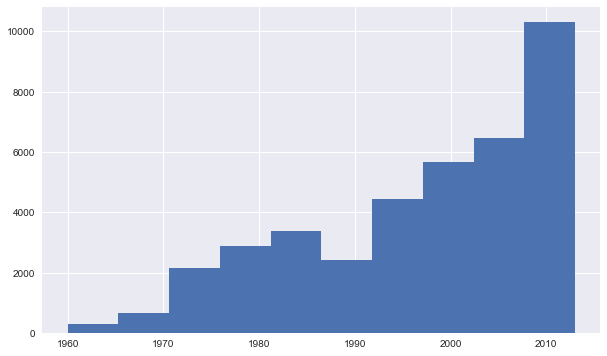

In [74]:
clean_train_values[clean_train_values != 0]['construction_year'].hist(figsize = (10,6));

There is no obvious way to impute these values and the pump's age will likely be a large factor in whether it is functional, so an naive approachcould really hurt the predictions of the model. So let's try something more sophisticated and use the sklearn imperative imputer function to impute the values. It is roughly based on the MICE method for imputing values.

In [75]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [76]:
# Imputer uses a regression on the data to impute the data, so the data must all be numerical
# We will ordinal encode every object type column for this purpose.
encoded_df = clean_train_values.copy()
categorical_cols = clean_train_values.select_dtypes(include = ['object', 'datetime64']).columns
encoded_df[categorical_cols] = encoded_df[categorical_cols].apply(LabelEncoder().fit_transform)

In [77]:
# Turning zeros to nan for the imputer to recognize them as missing
encoded_df['construction_year'] = encoded_df['construction_year'].replace(0, np.nan)

In [78]:
imp = IterativeImputer(random_state=42)
imp.fit(encoded_df)
encoded_df = imp.transform(encoded_df)

In [79]:
encoded_df[:, clean_train_values.columns.get_loc('construction_year')]

array([1999.        , 2010.        , 2009.        , ..., 2002.14321575,
       1996.00851017, 2002.        ])

In [80]:
clean_train_values.loc[:,'construction_year'] = encoded_df[:, clean_train_values.columns.get_loc('construction_year')]

In [81]:
clean_train_values.construction_year.value_counts().head(10)

2010.0    2645
2008.0    2613
2009.0    2533
2000.0    2091
2007.0    1587
2006.0    1471
2003.0    1286
2011.0    1256
2004.0    1123
2012.0    1084
Name: construction_year, dtype: int64

As we can see the imputer somehwat changed the distribution shape and added most of the missing values around the median value, though the effect is less extreme than if we simply imputed that they were all exactly the median value.

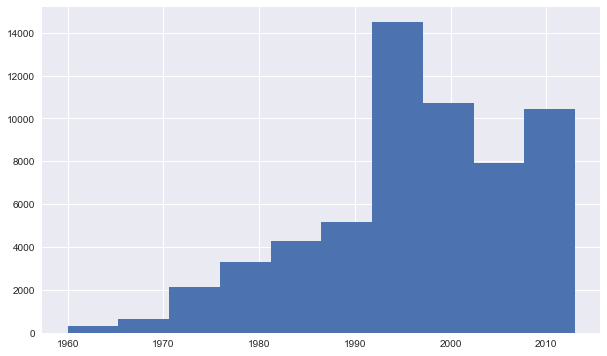

In [82]:
clean_train_values['construction_year'].hist(figsize = (10,6));

Although the construction year and the time that the pump was observed may havesome value as is. It is far more likely that the age of the pump at the time it was inspected and the time of year that it was inspected will be much more predictive. So, we will use the data to engineer a pump_age column and season column before dropping the date and construction year. 

Before we do that though lets look at the recorded years more closely. It is unusual that 2004 and 2002 are in the data, it is possible that they are data entry errors. Maybe they were meant to be 2012 and 2014?

In [83]:
pd.DatetimeIndex(clean_train_values['date_recorded']).year.value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: date_recorded, dtype: int64

There are a small number of these though so let's proceed.

In [84]:
import datetime
clean_train_values['recorded_year'] = pd.DatetimeIndex(clean_train_values['date_recorded']).year

In [85]:
clean_train_values['pump_age'] = clean_train_values['recorded_year'] - clean_train_values['construction_year']

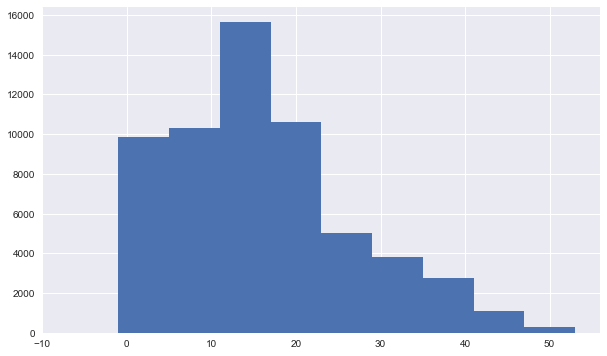

In [86]:
clean_train_values['pump_age'].hist(figsize = (10,6));

We can see that some of out imputed values, or the values for the date_recorded have errors, since some pump ages are negative

In [87]:
clean_train_values['pump_age'].min()

-7.0

Let's assume that the error is in the recorded dates and see how that changes things.

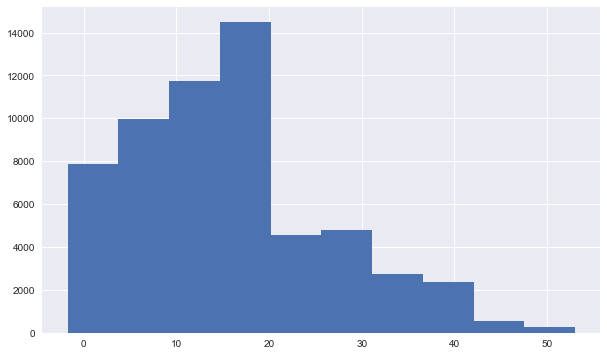

In [88]:
clean_train_values['recorded_year'] = clean_train_values['recorded_year'].replace({2002: 2012, 2004: 2014})
clean_train_values['pump_age'] = clean_train_values['recorded_year'] - clean_train_values['construction_year']
clean_train_values['pump_age'].hist(figsize = (10,6));

In [89]:
clean_train_values['pump_age'].min()

-1.731546586140439

In [90]:
clean_train_values['recorded_year'].value_counts()

2011    28674
2013    24271
2012     6425
2014       30
Name: recorded_year, dtype: int64

The issue is reduced, but not eliminated with this change. Let's leave it as is and proceed to making the season feature. Tanzania has four seasons, a short dry season, a long rainy season, a long dry season and a short rainy season, and the functioning of pumps may be better or worse in these different seasons.

In [91]:
clean_train_values['month'] = pd.DatetimeIndex(clean_train_values['date_recorded']).month

season_dict = {1: 'short dry', 2:'short dry', 3: 'long rain', 
                 4: 'long rain', 5: 'long rain',6: 'long dry', 
                 7: 'long dry', 8: 'long dry', 9: 'long dry', 
                 10: 'long dry', 11:'short rain', 12:'short rain'}
clean_train_values['season'] = clean_train_values['month'].replace(season_dict)

In [92]:
clean_train_values = clean_train_values.drop(columns=['month', 'recorded_year', 'construction_year', 'date_recorded'])

In [93]:
clean_train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              59400 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  object 
 7   subvillage             59400 non-null  object 
 8   region_code            59400 non-null  int64  
 9   district_code          59400 non-null  int64  
 10  lga                    59400 non-null  object 
 11  ward                   59400 non-null  object 
 12  population             59400 non-null  int64  
 13  public_meeting         59400 non-null  bool   
 14  scheme_management      59400 non-null  object 
 15  pe

### Total Static Head

Total static head is a measure of how many feet a pump can lift water. It is hard to tell if zero values are missing or if they represent systems that don't lift water. We won't impute any values for this for now, but may impute this value in the future and see if it impact the model performance.

In [94]:
clean_train_values.amount_tsh.value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

### Population

There is no clear way to tell whether the zero and 1 values represent that no one or one person is using the pump or if it is missing data, but we will assume that the 1 values aren't errors, and impute the other values by the mean in the location.

In [95]:
clean_train_values.population.value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

To impute the values we will find the mean of the population in the smallest region and impute the value and continue doing that for larger regions until all the nan values in regions with data have been replaced.

In [96]:
areas_lg_to_sm = ['region_code', 'district_code', 'ward', 'subvillage']

In [102]:
def impute_by_area(df, areas_lg_to_sm, col_name):
    areas = areas_lg_to_sm.copy()
    i = 0
    for area in areas_lg_to_sm:
        means_pop = df.groupby(areas)[col_name].mean().reset_index()
        means_pop = means_pop.rename(columns={col_name: col_name+'_'+areas[-1]})
        df = df.merge(means_pop, how = 'left', on = areas)
        if i == 0:
            df['imputed_'+col_name] = np.where(df[col_name].isna(),
                                                df[col_name+'_'+areas[-1]],
                                                df[col_name])
        else:
            df['imputed_'+col_name] = np.where(df['imputed_'+col_name].isna(),
                                                df[col_name+'_'+areas[-1]],
                                                df['imputed_'+col_name])
        areas = areas[:-1]
    #Imputes the total mean for any remaining uncaptured values
    df['imputed_'+col_name].fillna(df['imputed_'+col_name].mean())
    return df

In [98]:
clean_train_values['population'] = clean_train_values['population'].replace(0, np.nan)
clean_train_values = impute_by_area(clean_train_values, areas_lg_to_sm, 'population')
clean_train_values.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'region_code', 'district_code',
       'lga', 'ward', 'population', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'extraction_type_class', 'management',
       'management_group', 'payment', 'water_quality', 'quantity', 'source',
       'source_class', 'waterpoint_type', 'missing_meeting', 'missing_permit',
       'pump_age', 'season', 'population_subvillage', 'imputed_population',
       'population_ward', 'population_district_code',
       'population_region_code'],
      dtype='object')

In [106]:
clean_train_values.imputed_population.value_counts()1

300.459812     8819
1.000000       7025
428.359756     4847
200.875000     3316
552.070845     2680
               ... 
2210.000000       1
104.000000        1
561.000000        1
711.000000        1
2248.000000       1
Name: imputed_population, Length: 1059, dtype: int64

This is a slightly more reasonable distribution.

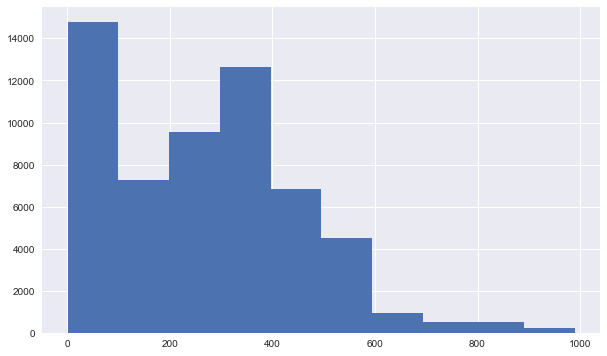

In [124]:
clean_train_values[clean_train_values['imputed_population'] < 1000]['imputed_population'].hist(figsize = (10,6));

In [107]:
clean_train_values = clean_train_values.drop(columns = ['population_subvillage',
                                                        'population',
                                                        'population_ward',
                                                        'population_district_code',
                                                        'population_region_code'])

### GPS Data

Both lat and long are missing values 1812 values. We can tell because a longitude of 0 would be outside the country.

In [108]:
clean_train_values.longitude.value_counts()

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
             ... 
37.579803       1
33.196490       1
34.017119       1
33.788326       1
30.163579       1
Name: longitude, Length: 57516, dtype: int64

In [109]:
clean_train_values.latitude.value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

There are many zeros in the height data, but it is impossible to entirely tell which are just sea level and which might be missing. But, it seems that the rows with missing lat-long are also have zeroes in their heights and thus are likely missing height info.

In [110]:
clean_train_values.gps_height.value_counts()

 0       20438
-15         60
-16         55
-13         55
-20         52
         ...  
 2285        1
 2424        1
 2552        1
 2413        1
 2385        1
Name: gps_height, Length: 2428, dtype: int64

In [111]:
clean_train_values['gps_height'][clean_train_values.longitude==0].value_counts()

0    1812
Name: gps_height, dtype: int64

Let's look more closely at some of the rows with 0 lat long data.

In [112]:
clean_train_values[clean_train_values.longitude==0].head()

amount_tsh       funder  gps_height   installer  longitude      latitude  \
21          0.0         dwsp           0         dwe        0.0 -2.000000e-08   
53          0.0   government           0  government        0.0 -2.000000e-08   
168         0.0          wvt           0         wvt        0.0 -2.000000e-08   
177         0.0  netherlands           0         dwe        0.0 -2.000000e-08   
253         0.0       hesawa           0         dwe        0.0 -2.000000e-08   

             basin  subvillage  region_code  district_code  ... water_quality  \
21   Lake Victoria  ibabachegu           17              1  ...       unknown   
53   Lake Victoria      center           19              6  ...       unknown   
168  Lake Victoria       ilula           17              1  ...          soft   
177  Lake Victoria      mahaha           17              1  ...          soft   
253  Lake Victoria   nyamatala           19              2  ...          soft   

         quantity                source source_class  \
21        unknown          shallow well  groundwater   
53            dry           machine dbh  groundwater   
168      seasonal  rainwater harvesting      surface   
177        enough          shallow well  groundwater   
253  insufficient          shallow well  groundwater   

                 waterpoint_type missing_meeting missing_permit   pump_age  \
21                     hand pump            True          False  23.484399   
53   communal standpipe multiple           False          False  28.463563   
168           communal standpipe           False          False  25.780906   
177                        other            True          False  24.234901   
253                    hand pump           False          False  32.270641   

        season imputed_population  
21   short dry         428.359756  
53    long dry         552.070845  
168  short dry         428.359756  
177  short dry         428.359756  
253   long dry         552.070845  

[5 rows x 30 columns]

Let's approach this problem the same way we did the population one by imputing the mean based on the smallest region that there is other data available.

In [113]:
#Imputing longitude values
clean_train_values['longitude'] = clean_train_values['longitude'].replace(0, np.nan)
clean_train_values = impute_by_area(clean_train_values, areas_lg_to_sm, 'longitude')
clean_train_values.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'region_code', 'district_code',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'permit',
       'extraction_type', 'extraction_type_class', 'management',
       'management_group', 'payment', 'water_quality', 'quantity', 'source',
       'source_class', 'waterpoint_type', 'missing_meeting', 'missing_permit',
       'pump_age', 'season', 'imputed_population', 'longitude_subvillage',
       'imputed_longitude', 'longitude_ward', 'longitude_district_code',
       'longitude_region_code'],
      dtype='object')

In [114]:
clean_train_values.imputed_longitude.value_counts()

33.244879    1057
33.091564     752
34.895027       3
37.542785       2
31.619530       2
             ... 
33.788326       1
37.371204       1
35.455622       1
34.628176       1
35.005922       1
Name: imputed_longitude, Length: 57518, dtype: int64

In [115]:
sum(clean_train_values['latitude'] ==-2.000000e-08) 

1812

In [116]:
#Imputing latitude values
clean_train_values['latitude'] = clean_train_values['latitude'].replace(-2.000000e-08, np.nan)
clean_train_values = impute_by_area(clean_train_values, areas_lg_to_sm, 'latitude')
clean_train_values.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'region_code', 'district_code',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'permit',
       'extraction_type', 'extraction_type_class', 'management',
       'management_group', 'payment', 'water_quality', 'quantity', 'source',
       'source_class', 'waterpoint_type', 'missing_meeting', 'missing_permit',
       'pump_age', 'season', 'imputed_population', 'longitude_subvillage',
       'imputed_longitude', 'longitude_ward', 'longitude_district_code',
       'longitude_region_code', 'latitude_subvillage', 'imputed_latitude',
       'latitude_ward', 'latitude_district_code', 'latitude_region_code'],
      dtype='object')

In [117]:
clean_train_values.imputed_latitude.value_counts()

-3.491473    1057
-2.620502     752
-8.904674       3
-6.965834       2
-6.964258       2
             ... 
-9.646831       1
-8.124530       1
-2.535985       1
-4.828176       1
-2.598965       1
Name: imputed_latitude, Length: 57519, dtype: int64

In [118]:
# Setting the rows with missing lat longs to nan values so they can be imputed
# we don't want to see all 0s to Nan since some may be coastline and thus already accurate
idx_missing_heights = train_values[train_values['longitude']==0].index 
height_col_num = clean_train_values.columns.get_loc('gps_height')
clean_train_values.iloc[idx_missing_heights, height_col_num] = np.nan
clean_train_values['gps_height'].isna().sum()

1812

In [119]:
clean_train_values = impute_by_area(clean_train_values, areas_lg_to_sm, 'gps_height')
clean_train_values.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'subvillage', 'region_code', 'district_code',
       'lga', 'ward', 'public_meeting', 'scheme_management', 'permit',
       'extraction_type', 'extraction_type_class', 'management',
       'management_group', 'payment', 'water_quality', 'quantity', 'source',
       'source_class', 'waterpoint_type', 'missing_meeting', 'missing_permit',
       'pump_age', 'season', 'imputed_population', 'longitude_subvillage',
       'imputed_longitude', 'longitude_ward', 'longitude_district_code',
       'longitude_region_code', 'latitude_subvillage', 'imputed_latitude',
       'latitude_ward', 'latitude_district_code', 'latitude_region_code',
       'gps_height_subvillage', 'imputed_gps_height', 'gps_height_ward',
       'gps_height_district_code', 'gps_height_region_code'],
      dtype='object')

In [120]:
clean_train_values.imputed_gps_height.value_counts()

 0.000000       18626
 56.034648       1057
 191.838344       752
-15.000000         60
-16.000000         55
                ...  
 2072.000000        1
 2353.000000        1
 622.000000         1
 2566.000000        1
-90.000000          1
Name: imputed_gps_height, Length: 2431, dtype: int64

In [121]:
clean_train_values = clean_train_values.drop(columns = ['longitude_subvillage',
                                                        'longitude',
                                                        'longitude_ward',
                                                        'longitude_district_code',
                                                        'longitude_region_code',
                                                        'latitude_subvillage',
                                                        'latitude',
                                                        'latitude_ward', 
                                                        'latitude_district_code', 
                                                        'latitude_region_code',
                                                        'gps_height_subvillage', 
                                                        'gps_height', 
                                                        'gps_height_ward',
                                                        'gps_height_district_code', 
                                                        'gps_height_region_code'])

Let's visualize the numeric data again before we proceed.

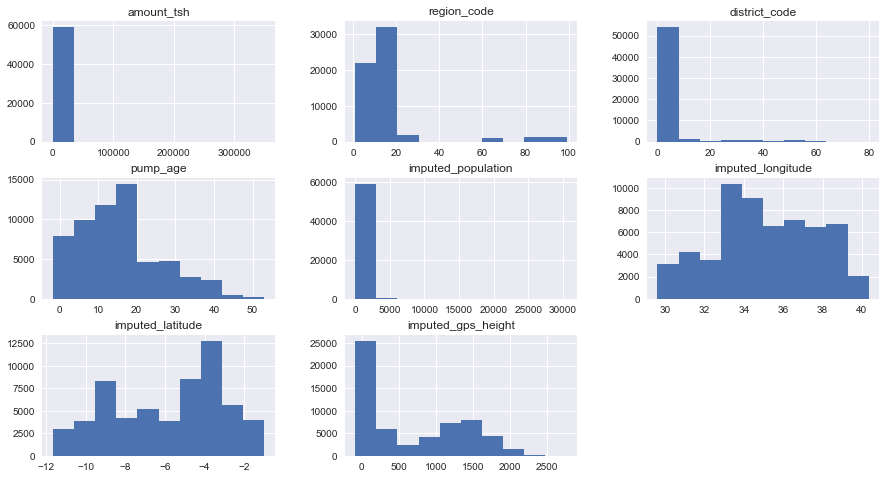

In [122]:
clean_train_values.select_dtypes(exclude=['object', 'bool']).hist(figsize = (15,8));

There is obviously still a lot of missing data, but let's proceed after pickling the cleaned data.

In [125]:
with open('data/clean_training_values.pickle', 'wb') as f:
    pickle.dump(clean_train_values, f)

## Label Data

There are no missing labels in the label data.

In [126]:
train_labels = pd.read_csv('data/training_set_labels.csv')
train_labels.head()

id    status_group
0  69572      functional
1   8776      functional
2  34310      functional
3  67743  non functional
4  19728      functional

In [127]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


There are three possible labels for the data. There is some unbalance in the label data with significantly fewer "functional needs repair" values.

In [128]:
train_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

## Building a Base Model

To begin, let's see how well a logistic model run with the categorical data label encoded performs and use that as our baseline.

In [130]:
with open('data/clean_training_values.pickle', 'rb') as file:
    X = pickle.load(file)

In [131]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   funder                 59400 non-null  object 
 2   installer              59400 non-null  object 
 3   basin                  59400 non-null  object 
 4   subvillage             59400 non-null  object 
 5   region_code            59400 non-null  int64  
 6   district_code          59400 non-null  int64  
 7   lga                    59400 non-null  object 
 8   ward                   59400 non-null  object 
 9   public_meeting         59400 non-null  bool   
 10  scheme_management      59400 non-null  object 
 11  permit                 59400 non-null  bool   
 12  extraction_type        59400 non-null  object 
 13  extraction_type_class  59400 non-null  object 
 14  management             59400 non-null  object 
 15  ma

We will stratify the data when performing the split so we get an equal proportion of each class in the trains and testing data, so there is enough of the rarer needs repair data in both sets of data.

In [132]:
y_label = LabelEncoder()
y = y_label.fit_transform(train_labels['status_group'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [133]:
y_label.classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [134]:
num_fun = sum(train_labels['status_group'] == 'functional')
num_repair = sum(train_labels['status_group'] == 'functional needs repair')
num_nonfun = sum(train_labels['status_group'] == 'non functional')

To deal with the class imbalence in the baseline model we will weight the data proportional to how frequent it is in the original training data.

In [135]:
weights = {0: 1, 1: num_fun/num_repair, 2: num_fun/num_nonfun}

In [136]:
categorical_cols = X.select_dtypes('object').columns

In [137]:
ct_ordinal = ColumnTransformer(transformers=[("ord", 
                                              OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
                                              categorical_cols)],
                               remainder="passthrough")

In [138]:
pipe_log = Pipeline(steps=[
    ("encode", ct_ordinal),
    ("scale", StandardScaler()),
    ("model", LogisticRegression(class_weight = weights, multi_class='multinomial'))])
pipe_log.fit(X_train, y_train)

Pipeline(steps=[('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['funder', 'installer', 'basin', 'subvillage', 'lga', 'ward',
       'scheme_management', 'extraction_type', 'extraction_type_class',
       'management', 'management_group', 'payment', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type', 'season'],
      dtype='object'))])),
                ('scale', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight={0: 1, 1: 7.472550382209868,
                                                  2: 1.4133806519453207},
                                    multi_class='multinomial'))])

The logistic regression model is not great with only an accuracy of around 53%.

In [139]:
def get_scores(model, X_test, y_test):
    acc = accuracy_score(y_test, model.predict(X_test))
    prec = precision_score(y_test, model.predict(X_test), average='weighted')
    f1 = f1_score(y_test, model.predict(X_test), average='weighted')
    rec = recall_score(y_test, model.predict(X_test), average='weighted')
    return {'Accuracy': acc, "Precision": prec, "Recall": rec, "F1 Score": f1}

In [140]:
get_scores(pipe_log, X_test, y_test)

{'Accuracy': 0.5341414141414141,
 'Precision': 0.6352916783320126,
 'Recall': 0.5341414141414141,
 'F1 Score': 0.5652026938599664}

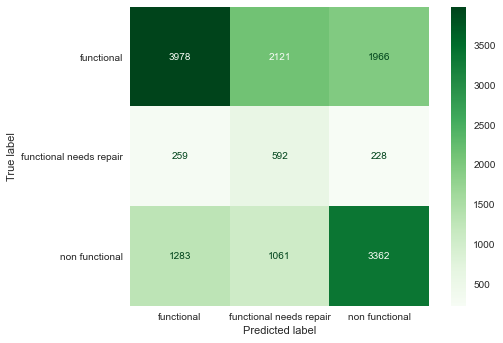

In [141]:
ConfusionMatrixDisplay.from_estimator(pipe_log, X_test, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

## Improving the Model

#### *One-Hot Encoding*

To begin let's see how the model's performance changes with a different method of encoding before seeing whether another method of modelind the data would be more effective. We will try one hot encoding all the columns with few than 30 categories.

In [142]:
one_hot_cat = [col for col in X.columns if (X[col].dtype == 'O' and len(X[col].unique()) < 30)]
one_hot_cat

['basin',
 'scheme_management',
 'extraction_type',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type',
 'season']

In [143]:
label_cat = [col for col in X.columns if (X[col].dtype == 'O' and len(X[col].unique()) >= 30)]
label_cat

['funder', 'installer', 'subvillage', 'lga', 'ward']

In [144]:
ct_mixed = ColumnTransformer(transformers=[("ord", 
                                              OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
                                              label_cat), ('ohe', OneHotEncoder(handle_unknown='ignore'), one_hot_cat)],
                               remainder="passthrough")

In [148]:
pipe_log_ohe = Pipeline(steps=[
    ("encode", ct_mixed),
    ("scale", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(class_weight = weights, multi_class='multinomial', max_iter=5000))])
pipe_log_ohe.fit(X_train, y_train)

Pipeline(steps=[('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['funder', 'installer',
                                                   'subvillage', 'lga',
                                                   'ward']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['basin', 'scheme_management',
                                                   'extraction_type',
                                                   'extraction_type_class',
                                                   'management',
                         

This took more iterations to converge, but is doing around 10% better.

In [150]:
get_scores(pipe_log_ohe, X_test, y_test)

{'Accuracy': 0.6336700336700337,
 'Precision': 0.7420870057283717,
 'Recall': 0.6336700336700337,
 'F1 Score': 0.6713341481711341}

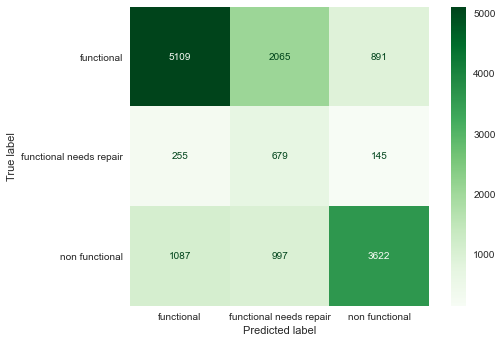

In [151]:
ConfusionMatrixDisplay.from_estimator(pipe_log_ohe, X_test, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

#### *Decision Tree*

In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [167]:
pipe_tree = Pipeline(steps=[
    ("encode", ct_mixed),
    ("scale", StandardScaler(with_mean=False)),
    ("model", DecisionTreeClassifier())])
pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['funder', 'installer',
                                                   'subvillage', 'lga',
                                                   'ward']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['basin', 'scheme_management',
                                                   'extraction_type',
                                                   'extraction_type_class',
                                                   'management',
                         

The decision tree performs about 11% better than the logistic model, but since it wasn't weighted like the logistic model it is doing worse on the rare 'needs repair" class.

In [168]:
get_scores(pipe_tree, X_test, y_test)

{'Accuracy': 0.7409427609427609,
 'Precision': 0.7438204242923625,
 'Recall': 0.7409427609427609,
 'F1 Score': 0.7420186433732177}

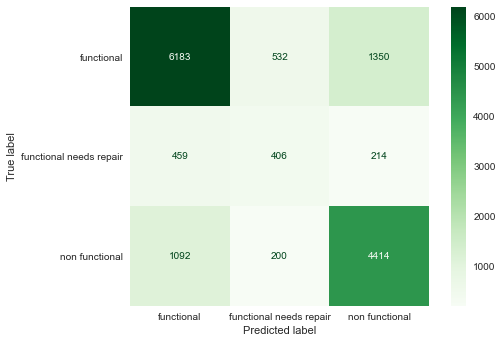

In [169]:
ConfusionMatrixDisplay.from_estimator(pipe_tree, X_test, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

Let's deal with the class imbalance issue by using oversampling with SMOTE.

In [170]:
pipe_presamp = Pipeline(steps=[("encode", ct_mixed),
                               ("scale", StandardScaler(with_mean=False))])
X_train_encoded = pipe_presamp.fit_transform(X_train)

In [171]:
sm = SMOTE()
X_train_resampled, y_train_resampled = sm.fit_sample(X_train_encoded, y_train) 

In [172]:
print(pd.Series(y_train_resampled).value_counts()) 

2    24194
1    24194
0    24194
dtype: int64


In [173]:
over_tree = DecisionTreeClassifier()
over_tree.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier()

The oversampled model does a bit better on the needs repair class, but with a small drop in overall accuracy.

In [174]:
X_test_encoded = pipe_presamp.transform(X_test)
get_scores(over_tree, X_test_encoded, y_test)

{'Accuracy': 0.7325925925925926,
 'Precision': 0.7432647155794098,
 'Recall': 0.7325925925925926,
 'F1 Score': 0.7371698988212358}

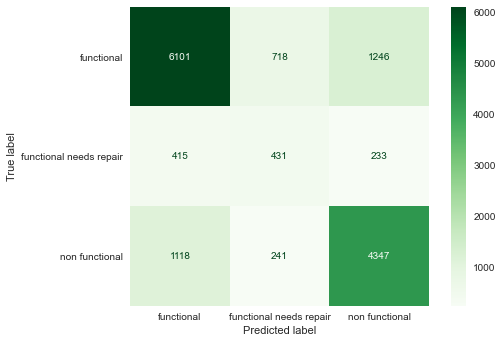

In [175]:
ConfusionMatrixDisplay.from_estimator(over_tree, X_test_encoded, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

#### *Bagged Tree*

In [176]:
pipe_bag_tree = Pipeline(steps=[
    ("encode", ct_mixed),
    ("scale", StandardScaler(with_mean=False)),
    ("model", BaggingClassifier(DecisionTreeClassifier(), n_estimators=20))])
pipe_bag_tree.fit(X_train, y_train)

Pipeline(steps=[('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['funder', 'installer',
                                                   'subvillage', 'lga',
                                                   'ward']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['basin', 'scheme_management',
                                                   'extraction_type',
                                                   'extraction_type_class',
                                                   'management',
                         

The bagged tree is about 6% better, but was obviously much slower.

In [179]:
get_scores(pipe_bag_tree, X_test, y_test)

{'Accuracy': 0.7955555555555556,
 'Precision': 0.7892951866108502,
 'Recall': 0.7955555555555556,
 'F1 Score': 0.7901450740193285}

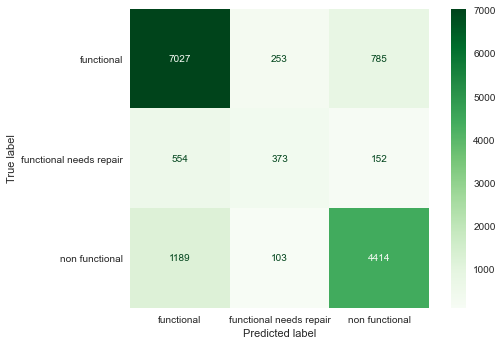

In [180]:
ConfusionMatrixDisplay.from_estimator(pipe_bag_tree, X_test, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

Again there is an issue with the needs repair class, let's try  using the over sampled data with the bagged tree.

In [181]:
over_bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=20)
over_bag.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=20)

The bagged tree does stilly more poorly with the oversampled data.

In [182]:
get_scores(over_bag, X_test_encoded, y_test)

{'Accuracy': 0.785050505050505,
 'Precision': 0.7857850104491468,
 'Recall': 0.785050505050505,
 'F1 Score': 0.7850671239327709}

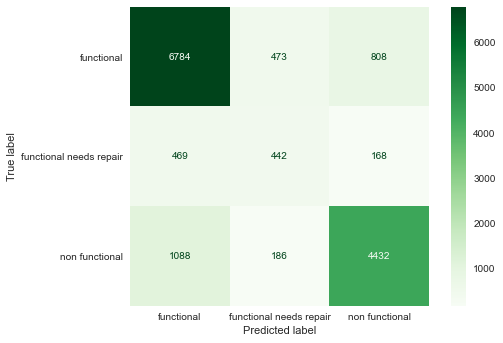

In [183]:
ConfusionMatrixDisplay.from_estimator(over_bag, X_test_encoded, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

#### *Random Forest*

In [184]:
pipe_forest = Pipeline(steps=[
    ("encode", ct_mixed),
    ("scale", StandardScaler(with_mean=False)),
    ("model", RandomForestClassifier())])
pipe_forest.fit(X_train, y_train)

Pipeline(steps=[('encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['funder', 'installer',
                                                   'subvillage', 'lga',
                                                   'ward']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['basin', 'scheme_management',
                                                   'extraction_type',
                                                   'extraction_type_class',
                                                   'management',
                         

This is about the best score so far, but still does very poorly on needs_repair.

In [185]:
get_scores(pipe_forest, X_test, y_test)

{'Accuracy': 0.8103030303030303,
 'Precision': 0.8042123516905415,
 'Recall': 0.8103030303030303,
 'F1 Score': 0.8043811006952861}

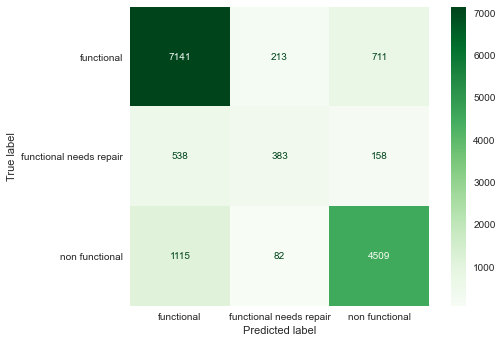

In [186]:
ConfusionMatrixDisplay.from_estimator(pipe_forest, X_test, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

In [187]:
over_forest = RandomForestClassifier()
over_forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

This performs slightly worse, but a bit better on the needs repair data.

In [188]:
get_scores(over_forest, X_test_encoded, y_test)

{'Accuracy': 0.7998653198653198,
 'Precision': 0.7995058623338085,
 'Recall': 0.7998653198653198,
 'F1 Score': 0.7992548691476987}

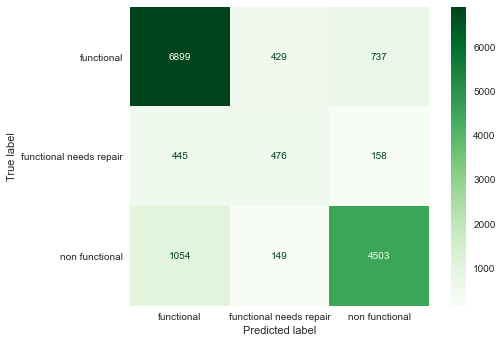

In [189]:
ConfusionMatrixDisplay.from_estimator(over_forest, X_test_encoded, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

#### *XGBoost*

Let's try running XGBoost on the raw data and then the oversampled data to see how it performs.

In [190]:
from xgboost import XGBClassifier

In [191]:
xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder = False)
xgb.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

XGBoost is doing a bit worse than the random forest model with default hyper parameters, and also struggles with the needs repair category.

In [192]:
get_scores(xgb, X_test_encoded, y_test)

{'Accuracy': 0.7981144781144781,
 'Precision': 0.7919185553160704,
 'Recall': 0.7981144781144781,
 'F1 Score': 0.787634372195772}

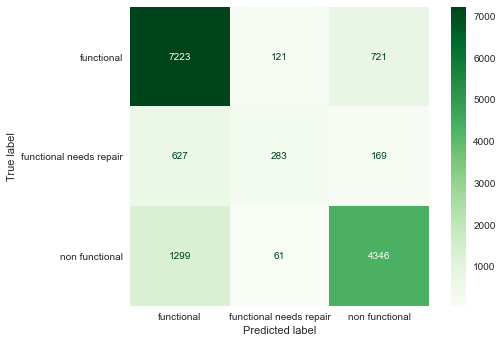

In [193]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test_encoded, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

In [194]:
over_xgb = XGBClassifier(eval_metric= 'mlogloss', use_label_encoder = False)
over_xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

As with the other models, XGBoost does worse overall with the over sampled data, but much better on the needs repairs category.

In [195]:
get_scores(over_xgb, X_test_encoded, y_test)

{'Accuracy': 0.7622222222222222,
 'Precision': 0.7771571651614501,
 'Recall': 0.7622222222222222,
 'F1 Score': 0.7681108265614855}

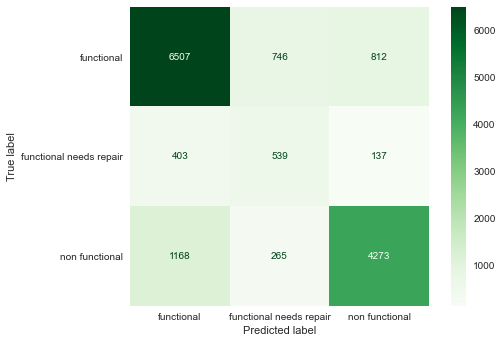

In [196]:
ConfusionMatrixDisplay.from_estimator(over_xgb, X_test_encoded, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

#### Catboost

Let's try Catboost and see how it does.

In [226]:
from catboost import CatBoostClassifier, Pool

In [233]:
test_data = catboost_pool = Pool(X_train_encoded, y_train)

cat = CatBoostClassifier(iterations=750,
                           depth=7,
                           loss_function='MultiClass',
                           verbose=False)

cat.fit(X_train_encoded, y_train)

It appears to do slightly better than XGBoost, but worse than the forest

In [234]:
get_scores(cat, X_test_encoded, y_test)

{'Accuracy': 0.8,
 'Precision': 0.7936357834422056,
 'Recall': 0.8,
 'F1 Score': 0.7901391103309825}

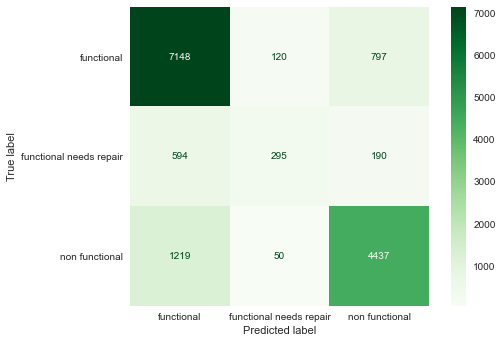

In [235]:
ConfusionMatrixDisplay.from_estimator(cat, X_test_encoded, y_test, display_labels=y_label.classes_, cmap="Greens")
plt.grid(False)
plt.show()

## *Tuning the Models*

#### Bagging Model

In [197]:
from sklearn.model_selection import GridSearchCV

In [200]:
param_bag = {
    'max_features': [0.2, 0.3, 0.4],
    'n_estimators': [100, 500, 1000]}

In [204]:
grid_bag = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                        param_bag,
                        scoring='accuracy',
                        cv=3,
                        n_jobs=1, 
                        verbose=2)
grid_bag.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .................max_features=0.2, n_estimators=100; total time=  42.7s
[CV] END .................max_features=0.2, n_estimators=100; total time=  36.3s
[CV] END .................max_features=0.2, n_estimators=100; total time=  42.2s
[CV] END .................max_features=0.2, n_estimators=500; total time= 3.5min
[CV] END .................max_features=0.2, n_estimators=500; total time= 3.5min
[CV] END .................max_features=0.2, n_estimators=500; total time= 3.4min
[CV] END ................max_features=0.2, n_estimators=1000; total time= 7.1min
[CV] END ................max_features=0.2, n_estimators=1000; total time= 6.8min
[CV] END ................max_features=0.2, n_estimators=1000; total time= 6.8min
[CV] END .................max_features=0.3, n_estimators=100; total time= 1.1min
[CV] END .................max_features=0.3, n_estimators=100; total time= 1.1min
[CV] END .................max_features=0.3, n_est

GridSearchCV(cv=3,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=1,
             param_grid={'max_features': [0.2, 0.3, 0.4],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy', verbose=2)

In [205]:
best_parameters = grid_bag.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
max_features: 0.4
n_estimators: 1000


Tuning increases its performance by about 2% but made the model take much longer to produce predictions.

In [207]:
get_scores(grid_bag, X_test_encoded, y_test)

{'Accuracy': 0.8154882154882155,
 'Precision': 0.8094540562664334,
 'Recall': 0.8154882154882155,
 'F1 Score': 0.8078731552830866}

#### Random Forest Model

In [212]:
param_forest = {
    'max_depth': [30, 60],
    'n_estimators': [100, 200, 300]}

In [214]:
grid_forest = GridSearchCV(RandomForestClassifier(),
                           param_forest,
                           scoring='accuracy',
                           cv=3,
                           n_jobs=1,
                           verbose=2)
grid_forest.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .....................max_depth=30, n_estimators=100; total time=  38.7s
[CV] END .....................max_depth=30, n_estimators=100; total time=  39.8s
[CV] END .....................max_depth=30, n_estimators=100; total time=  41.5s
[CV] END .....................max_depth=30, n_estimators=200; total time= 1.3min
[CV] END .....................max_depth=30, n_estimators=200; total time= 1.3min
[CV] END .....................max_depth=30, n_estimators=200; total time= 1.3min
[CV] END .....................max_depth=30, n_estimators=300; total time= 1.9min
[CV] END .....................max_depth=30, n_estimators=300; total time= 1.9min
[CV] END .....................max_depth=30, n_estimators=300; total time= 1.9min
[CV] END .....................max_depth=60, n_estimators=100; total time=  39.2s
[CV] END .....................max_depth=60, n_estimators=100; total time=  38.9s
[CV] END .....................max_depth=60, n_est

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': [30, 60],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [215]:
best_parameters = grid_forest.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
max_depth: 60
n_estimators: 300


The optimal parameters in the grid performed only marginally better than the default

In [216]:
get_scores(grid_forest, X_test_encoded, y_test)

{'Accuracy': 0.8105723905723906,
 'Precision': 0.8045263788416468,
 'Recall': 0.8105723905723906,
 'F1 Score': 0.8044390510280013}

#### XGBoost

In [218]:
param_xgb = {
    'eta': [0.2],
    'colsample_bytree': [0.3],
    'max_depth': [10, 20, 30],
    'n_estimators': [200, 400]}

In [219]:
grid_xgb = GridSearchCV(XGBClassifier(eval_metric= 'mlogloss', use_label_encoder = False),
                           param_xgb,
                           scoring='accuracy',
                           cv=3,
                           n_jobs=1,
                           verbose=2)
grid_xgb.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=10, n_estimators=200; total time=  15.9s
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=10, n_estimators=200; total time=  16.9s
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=10, n_estimators=200; total time=  16.8s
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=10, n_estimators=400; total time=  31.4s
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=10, n_estimators=400; total time=  33.1s
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=10, n_estimators=400; total time=  32.7s
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=20, n_estimators=200; total time=  30.9s
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=20, n_estimators=200; total time=  33.2s
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=20, n_estimators=200; total time=  33.2s
[CV] END colsample_bytree=0.3, eta=0.2, max_depth=20, n_estimators=400; total time=  56.9s
[CV] END colsample_bytree=0.3,

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mon...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                             

In [220]:
best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
colsample_bytree: 0.3
eta: 0.2
max_depth: 10
n_estimators: 200


The tuned model is about 2% better than the untuned one.

In [221]:
get_scores(grid_xgb, X_test_encoded, y_test)

{'Accuracy': 0.8097643097643098,
 'Precision': 0.8025225706345431,
 'Recall': 0.8097643097643098,
 'F1 Score': 0.8015831975904446}

#### Catboost

In [236]:
param_cat = {
    'iterations': [1000, 2000],
    'max_depth': [7, 9],
    'rsm': [0.2, 0.3]}

In [238]:
grid_cat = GridSearchCV(CatBoostClassifier(loss_function='MultiClass', verbose=False),
                        param_cat,
                        scoring='accuracy',
                        cv=3,
                        n_jobs=1,
                        verbose=2)
grid_cat.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..............iterations=1000, max_depth=7, rsm=0.2; total time=  18.5s
[CV] END ..............iterations=1000, max_depth=7, rsm=0.2; total time=  17.2s
[CV] END ..............iterations=1000, max_depth=7, rsm=0.2; total time=  17.1s
[CV] END ..............iterations=1000, max_depth=7, rsm=0.3; total time=  19.4s
[CV] END ..............iterations=1000, max_depth=7, rsm=0.3; total time=  17.1s
[CV] END ..............iterations=1000, max_depth=7, rsm=0.3; total time=  16.7s
[CV] END ..............iterations=1000, max_depth=9, rsm=0.2; total time=  27.1s
[CV] END ..............iterations=1000, max_depth=9, rsm=0.2; total time=  26.3s
[CV] END ..............iterations=1000, max_depth=9, rsm=0.2; total time=  25.8s
[CV] END ..............iterations=1000, max_depth=9, rsm=0.3; total time=  29.4s
[CV] END ..............iterations=1000, max_depth=9, rsm=0.3; total time=  29.4s
[CV] END ..............iterations=1000, max_depth

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002115C2BDA30>,
             n_jobs=1,
             param_grid={'iterations': [1000, 2000], 'max_depth': [7, 9],
                         'rsm': [0.2, 0.3]},
             scoring='accuracy', verbose=2)

In [240]:
best_parameters = grid_cat.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
iterations: 2000
max_depth: 9
rsm: 0.2


In [239]:
get_scores(grid_cat, X_test_encoded, y_test)

{'Accuracy': 0.8035690235690236,
 'Precision': 0.7963039095904026,
 'Recall': 0.8035690235690236,
 'F1 Score': 0.7954789679855238}

## Voting Model

In [241]:
from sklearn.ensemble import VotingClassifier

In [242]:
tuned_bag = BaggingClassifier(DecisionTreeClassifier(),max_features=0.4, n_estimators=1000)
tuned_forest = RandomForestClassifier(max_depth=60, n_estimators=300)
tuned_xgb = XGBClassifier(eval_metric='mlogloss',
                          use_label_encoder=False,
                          colsample_bytree=0.3,
                          eta=0.2,
                          max_depth=10,
                          n_estimators=200)
tuned_cat = CatBoostClassifier(loss_function='MultiClass',
                               verbose=False,
                               iterations=2000,
                               max_depth=9,
                               rsm=0.2)

In [244]:
vote = VotingClassifier(estimators=[('bag', tuned_bag),
                                    ('forest', tuned_forest),
                                    ('xbg', tuned_xgb),
                                    ('cat', tuned_cat)],
                        voting='soft')
vote.fit(X_train_encoded, y_train)

VotingClassifier(estimators=[('bag',
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                                max_features=0.4,
                                                n_estimators=1000)),
                             ('forest',
                              RandomForestClassifier(max_depth=60,
                                                     n_estimators=300)),
                             ('xbg',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3,
                                            enable_categorical=False, eta=0.2,
                                            eval_...
                                            min_child_weight=None, missing=nan,
                                  

In [245]:
get_scores(vote, X_test_encoded, y_test)

{'Accuracy': 0.8156902356902357,
 'Precision': 0.8097024238032882,
 'Recall': 0.8156902356902357,
 'F1 Score': 0.8081592793552759}